In [1]:
import pandas as pd
import os
from tqdm import tqdm
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
navis_dir = os.path.join(data_dir, 'navis')
n101_folder = os.path.join(navis_dir, 'navis_101/csv_files')
n102_folder = os.path.join(navis_dir, 'navis_102/csv_files')

In [3]:
#set the cal val for N101
chl_dark = 51
chl_slope = 0.001553

beta_dark = 92
beta_slope = 0.0000002485

fdom_dark = 52
fdom_slope = 0.01118

In [4]:
def open_navis(filepath, float_ref):
    raw_var = ['mtime', 'pnum', 'lat', 'lon', 'pres', 'T', 'C', 'oxy1', 'oxy2', 'mcoms1', 'mcoms2', 'mcoms3']
    new_colnames = ['datetime', 'prof', 'lat', 'lon', 'pres', 'temp', 'conductivity', 'oxy1', 'oxy2', 'mcoms1', 'mcoms2', 'mcoms3']
    df = pd.read_csv(filepath)
    df_raw = df[raw_var]
    df_raw.columns = new_colnames

    df_computed = df_raw.copy()

    df_computed.loc[:, 'Fchl'] = (df_raw['mcoms1'] - chl_dark) * chl_slope
    df_computed.loc[:, 'beta'] = (df_raw['mcoms2'] - chl_dark) * chl_slope
    df_computed.loc[:, 'fdom'] = (df_raw['mcoms3'] - chl_dark) * chl_slope

    df_computed.loc[:, 'float'] = float_ref

    return(df_computed)

In [5]:
new_colnames = ['datetime', 'prof', 'lat', 'lon', 'pres', 'temp', 'conductivity', 'oxy1', 'oxy2', 'mcoms1', 'mcoms2', 'mcoms3']
compiled_101 = pd.DataFrame(columns=new_colnames)
for file in tqdm(os.listdir(n101_folder)):
    filepath = os.path.join(n101_folder, file)
    temp_df = open_navis(filepath, 'navis101')
    compiled_101 = pd.concat([compiled_101, temp_df], ignore_index= True)

  0%|          | 0/88 [00:00<?, ?it/s]C:\Users\flapet\AppData\Local\Temp\ipykernel_11008\213775207.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compiled_101 = pd.concat([compiled_101, temp_df], ignore_index= True)
100%|██████████| 88/88 [00:01<00:00, 50.02it/s]


In [6]:
#set the cal val for N102
chl_dark = 50
chl_slope = 0.002006

beta_dark = 49
beta_slope = 0.0000003524

fdom_dark = 51
fdom_slope = 0.006619

In [7]:
new_colnames = ['datetime', 'prof', 'lat', 'lon', 'pres', 'temp', 'conductivity', 'oxy1', 'oxy2', 'mcoms1', 'mcoms2', 'mcoms3']
compiled_102 = pd.DataFrame(columns=new_colnames)
for file in tqdm(os.listdir(n102_folder)):
    filepath = os.path.join(n102_folder, file)
    temp_df = open_navis(filepath, 'navis102')
    compiled_102 = pd.concat([compiled_102, temp_df], ignore_index= True)

  0%|          | 0/93 [00:00<?, ?it/s]C:\Users\flapet\AppData\Local\Temp\ipykernel_11008\798626295.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compiled_102 = pd.concat([compiled_102, temp_df], ignore_index= True)
100%|██████████| 93/93 [00:02<00:00, 44.62it/s]


In [8]:
navis_df = pd.concat([compiled_101, compiled_102])
navis_position = navis_df[['datetime', 'prof', 'float', 'lon', 'lat']].drop_duplicates(subset = ['prof', 'float'])
navis_df['JULD'] = pd.to_datetime(navis_df['datetime'])

In [9]:
navis_df.to_csv(os.path.join(navis_dir, 'merged_table'))

In [10]:
navis_position.columns = ['JULD', 'PROF_NUM', 'float', 'LONGITUDE', 'LATITUDE']
navis_position['JULD'] = navis_position['JULD'].astype(str)

In [11]:
def clean_datetime_column(df, column):
    # Identify rows that do not match the expected datetime format
    mask = df[column].str.contains(r'^\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}$', regex=True)
    
    # Print the rows that are problematic
    print("\nProblematic entries:")
    print(df[~mask])
    
    # Filter out problematic rows or handle them accordingly
    cleaned_df = df[mask].copy()
    
    return cleaned_df

In [12]:
cleaned_navis_position = navis_position.copy()

In [13]:
cleaned_navis_position.head()

,JULD,PROF_NUM,float,LONGITUDE,LATITUDE
0,2022/07/25 20:38:11,2,navis101,-23.1665,58.1415
489,2022/07/30 21:10:54,3,navis101,-22.6485,58.4391
977,2022/08/04 13:19:01,4,navis101,-21.9113,58.7442
1465,2022/08/09 01:28:42,5,navis101,-22.5342,59.1069
1955,2022/08/13 12:31:46,6,navis101,-22.5308,59.3274


In [14]:
cleaned_navis_position['JULD'] = pd.to_datetime(cleaned_navis_position['JULD'])

In [15]:
wmo_list = [4903532, 1902637]
#Float 1 = test float in the Icelandic Bassin
float_1_url = 'https://data-argo.ifremer.fr/dac/aoml/4903532/4903532_Sprof.nc'
#Float 2 = test float on Custard with glider next to it
float_2_url = 'https://data-argo.ifremer.fr/dac/coriolis/1902637/1902637_Sprof.nc'

#List the floats
floats_url = [float_1_url, float_2_url]

#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
floats_dir =  os.path.join(parent_dir, 'Data/Floats')

#Create floats filename
floats_filenames = []
for i in floats_url:
    filename = floats_dir + '/' + i.rsplit('/', 1)[1]
    floats_filenames.append(filename)

position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
last_position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})

for file, wmo in zip(floats_filenames, wmo_list):
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE', 'JULD']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    last_temp_df = temp_df[temp_df['JULD'] == max(temp_df['JULD'])]

    last_position_df = pd.concat([last_position_df, last_temp_df], ignore_index=True)
    position_df = pd.concat([position_df, temp_df], ignore_index=True)
    dat.close()

C:\Users\flapet\AppData\Local\Temp\ipykernel_11008\173837214.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  last_position_df = pd.concat([last_position_df, last_temp_df], ignore_index=True)
C:\Users\flapet\AppData\Local\Temp\ipykernel_11008\173837214.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  position_df = pd.concat([position_df, temp_df], ignore_index=True)


In [16]:
navis_position['JULD'] = pd.to_datetime(navis_position['JULD'])
full_position = pd.concat([position_df, navis_position], ignore_index = True)

most_recent_date = pd.to_datetime(full_position['JULD']).max().strftime('%Y_%m_%d')
output_filename = f'Float_positions_{most_recent_date}.csv'
# Save the dataframe to a CSV file
full_position.to_csv(output_filename, index=False)

In [17]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

# Define data's extents I used an arbitrary extent that depicts the Icelandic Bassin
min_lon = -35
max_lon = -5
min_lat = 55
max_lat = 66

In [18]:
bath_directory = parent_dir + '/Data/' + "ne_10m_bathymetry_all/"
def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    #r = requests.get(zip_file_url)
    #z = zipfile.ZipFile(io.BytesIO(r.content))
    #z.extractall(bath_directory)

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob(bath_directory + '*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (min_lon - 3, max_lon + 3,min_lat - 1, max_lat + 1)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict

In [19]:
import cartopy.io.shapereader as shpreader
depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

C:\Users\flapet\AppData\Local\Temp\ipykernel_11008\3351144274.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(formatted_date)


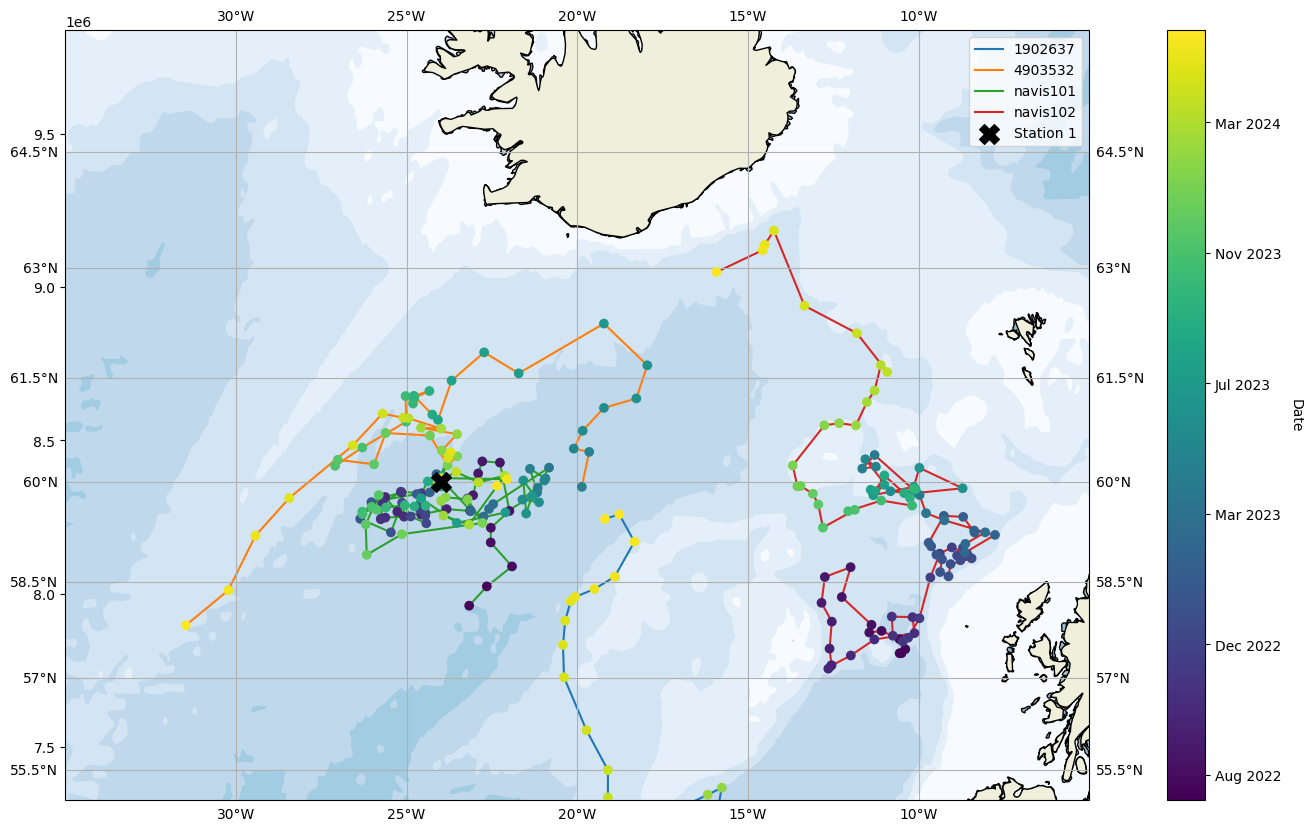

In [25]:
import matplotlib
from datetime import datetime
grouped = full_position.groupby('float')

# Construct a discrete colormap with colors corresponding to each depth
depths = depths_str.astype(int)
N = len(depths)
nudge = 0.01  # shift bin edge slightly to include data
boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
norm = matplotlib.colors.BoundaryNorm(boundaries, N)
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
colors_depths = blues_cm(norm(depths))

# Set up plot
# Initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1,
                    projection=ccrs.Mercator())

# Set the map extent based on your latitude and longitude ranges
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Scatter plot
sc = ax.scatter(full_position['LONGITUDE'], full_position['LATITUDE'], transform=ccrs.PlateCarree(), c = full_position['JULD'], zorder = 3)

#set the plot color bar
cbar = plt.colorbar(sc, ax = ax, label='Date')
cbar.set_label('Date', rotation=270, labelpad=15)

float_array = cbar.ax.get_yticks()
formatted_date = np.vectorize(lambda x: datetime.fromtimestamp(float(x) / 1e9).strftime("%b %Y"))(float_array)
cbar.ax.set_yticklabels(formatted_date)

for i, depth_str in enumerate(depths_str):
    ax.add_geometries(shp_dict[depth_str].geometries(),
                        crs=ccrs.PlateCarree(),
                        color=colors_depths[i])

for name, group in grouped:
    group.plot(x='LONGITUDE', y='LATITUDE', ax=ax, transform=ccrs.PlateCarree(), label=name, zorder=2)

ax.scatter(-24, 60, marker = 'X', s = 200, label = 'Station 1', transform = ccrs.PlateCarree(), c = 'Black', zorder = 3)
# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(land_50m)
ax.stock_img()

plt.legend()

# print a grid on it
gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, crs=ccrs.PlateCarree())

# Convert vector bathymetries to raster (saves a lot of disk space)
# while leaving labels as vectors
ax.set_rasterized(True)